# EPIC-2037_Fitting+MCMC

Using EPIC-2037 (K2-24) dataset, we demonstrate how to

- perform a max-likelihood fit
- do an MCMC exploration of the posterior space



In [19]:
# Preliminary imports
%pylab inline
import radvel
reload(radvel.likelihood)
import radvel.plotting
import pandas as pd
import os
from scipy import optimize
import corner
rc('savefig',dpi=120)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [20]:
# Load up EPIC-2037 data
path = os.path.join(radvel.DATADIR,'epic203771098.hdf')
planet = pd.read_hdf(path,'planet')
rv = pd.read_hdf(path,'rv')
def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(2,basis='per tc secosw sesinw logk')
    params['per1'] = planet.ix['P','b']
    params['tc1'] = planet.ix['t0','b']
    params['secosw1'] = 0.01
    params['sesinw1'] = 0.01
    params['logk1'] = 1.1
    params['per2'] = planet.ix['P','c']
    params['tc2'] = planet.ix['t0','c']
    params['secosw2'] = 0.01
    params['sesinw2'] = 0.01
    params['logk2'] = 1.1
    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = -0.02
    mod.params['curv'] = 0.01
    return mod

t = np.array(rv.t)
vel = np.array(rv.vel)
errvel = rv.errvel
ti = linspace(rv.t.iloc[0]-5,rv.t.iloc[-1]+5,100)

In [21]:
# Convenience function to plot model and residuals
def plot_results(like):
    fig = gcf()
    errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plot(ti, like.model(ti))
    fig.set_tight_layout(True)
    xlabel('Time')
    ylabel('RV')
    draw()

Fit EPIC-2307 RV data
=========================
1. circular orbits
2. fixed period, time of transit

In [22]:
# Set initial values of the parameters
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 0.1
like.params['jit'] = 1.0
like

parameter                     value      vary
curv                           0.01       True
dvdt                          -0.02       True
gamma                           0.1       True
jit                               1       True
logk1                           1.1       True
logk2                           1.1       True
per1                        20.8851       True
per2                        42.3638       True
secosw1                        0.01       True
secosw2                        0.01       True
sesinw1                        0.01       True
sesinw2                        0.01       True
tc1                          2072.8       True
tc2                         2082.62       True

parameter                     value      vary
curv                           0.01       True
dvdt                          -0.02       True
gamma                           0.1       True
jit                               1       True
logk1                           1.1       True
logk2                           1.1       True
per1                        20.8851      False
per2                        42.3638      False
secosw1                        0.01      False
secosw2                        0.01      False
sesinw1                        0.01      False
sesinw2                        0.01      False
tc1                          2072.8      False
tc2                         2082.62      False



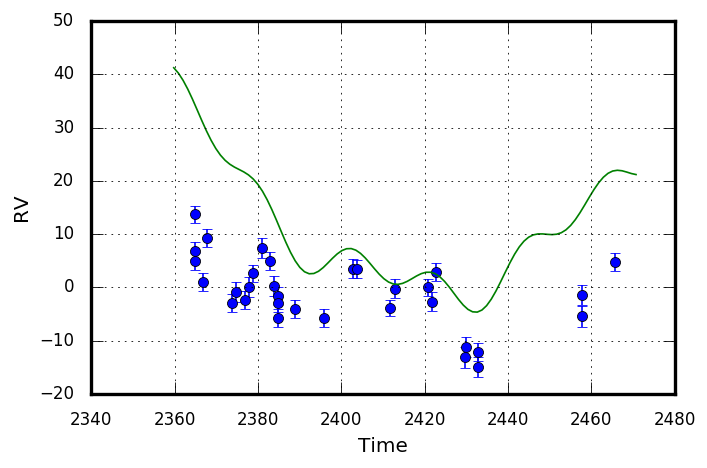

In [23]:



# Determin which parameters vary and which do not
like.vary['secosw1'] = False
like.vary['sesinw1'] = False
like.vary['secosw2'] = False
like.vary['sesinw2'] = False
like.vary['per1'] = False
like.vary['per2'] = False
like.vary['tc1'] = False
like.vary['tc2'] = False
like.vary['curv'] = True

figure()
plot_results(like) # Plot initial model
print like

parameter                     value      vary
curv                       0.001804       True
dvdt                     -0.0299544       True
gamma                      -3.97918       True
jit                         2.06908       True
logk1                        1.5468       True
logk2                       1.37737       True
per1                        20.8851      False
per2                        42.3638      False
secosw1                        0.01      False
secosw2                        0.01      False
sesinw1                        0.01      False
sesinw2                        0.01      False
tc1                          2072.8      False
tc2                         2082.62      False
Priors
------
Gaussian prior on jit, mu=1.09861228867, sigma=0.5
Gaussian prior on logk2, mu=1.60943791243, sigma=10
Gaussian prior on logk1, mu=1.60943791243, sigma=10
Gaussian prior on gamma, mu=0, sigma=10



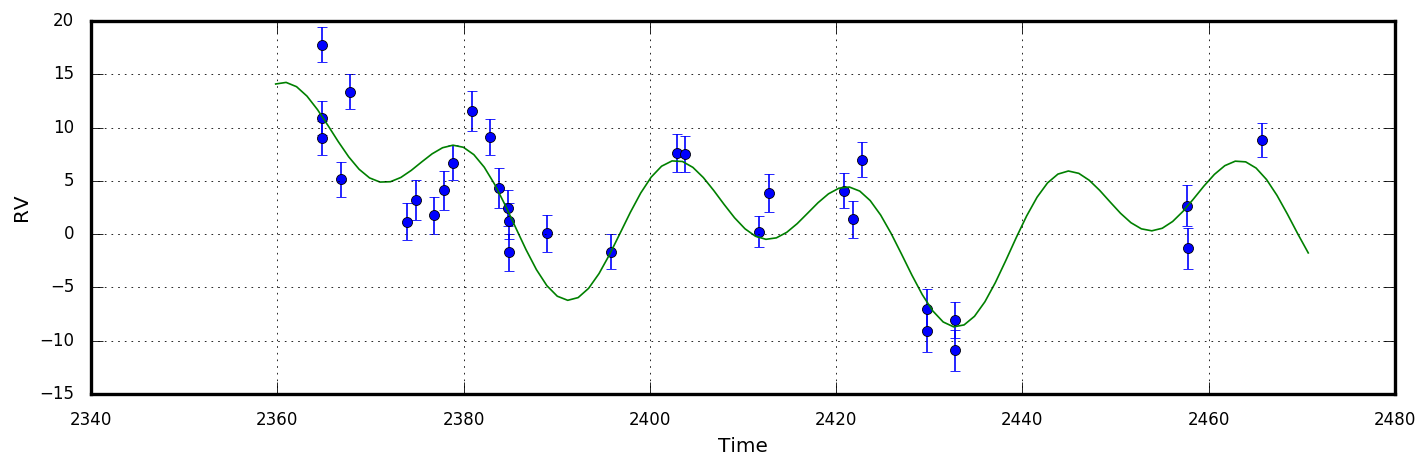

In [24]:
post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.Gaussian( 'jit', log(3), 0.5)]
post.priors += [radvel.prior.Gaussian( 'logk2', log(5), 10)]
post.priors += [radvel.prior.Gaussian( 'logk1', log(5), 10)]
post.priors += [radvel.prior.Gaussian( 'gamma', 0, 10)]

res  = optimize.minimize(
    post.neglogprob_array, # objective function is negative log likelihood
    post.get_vary_params(), # initial variable parameters
    method='Powell', # Nelder-Mead also works
    )

#print res
#print like_syn
fig = figsize(12,4)
plot_results(like) # plot best fit model
print post


Discarding burn-in now that the chains are marginally well-mixed



MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


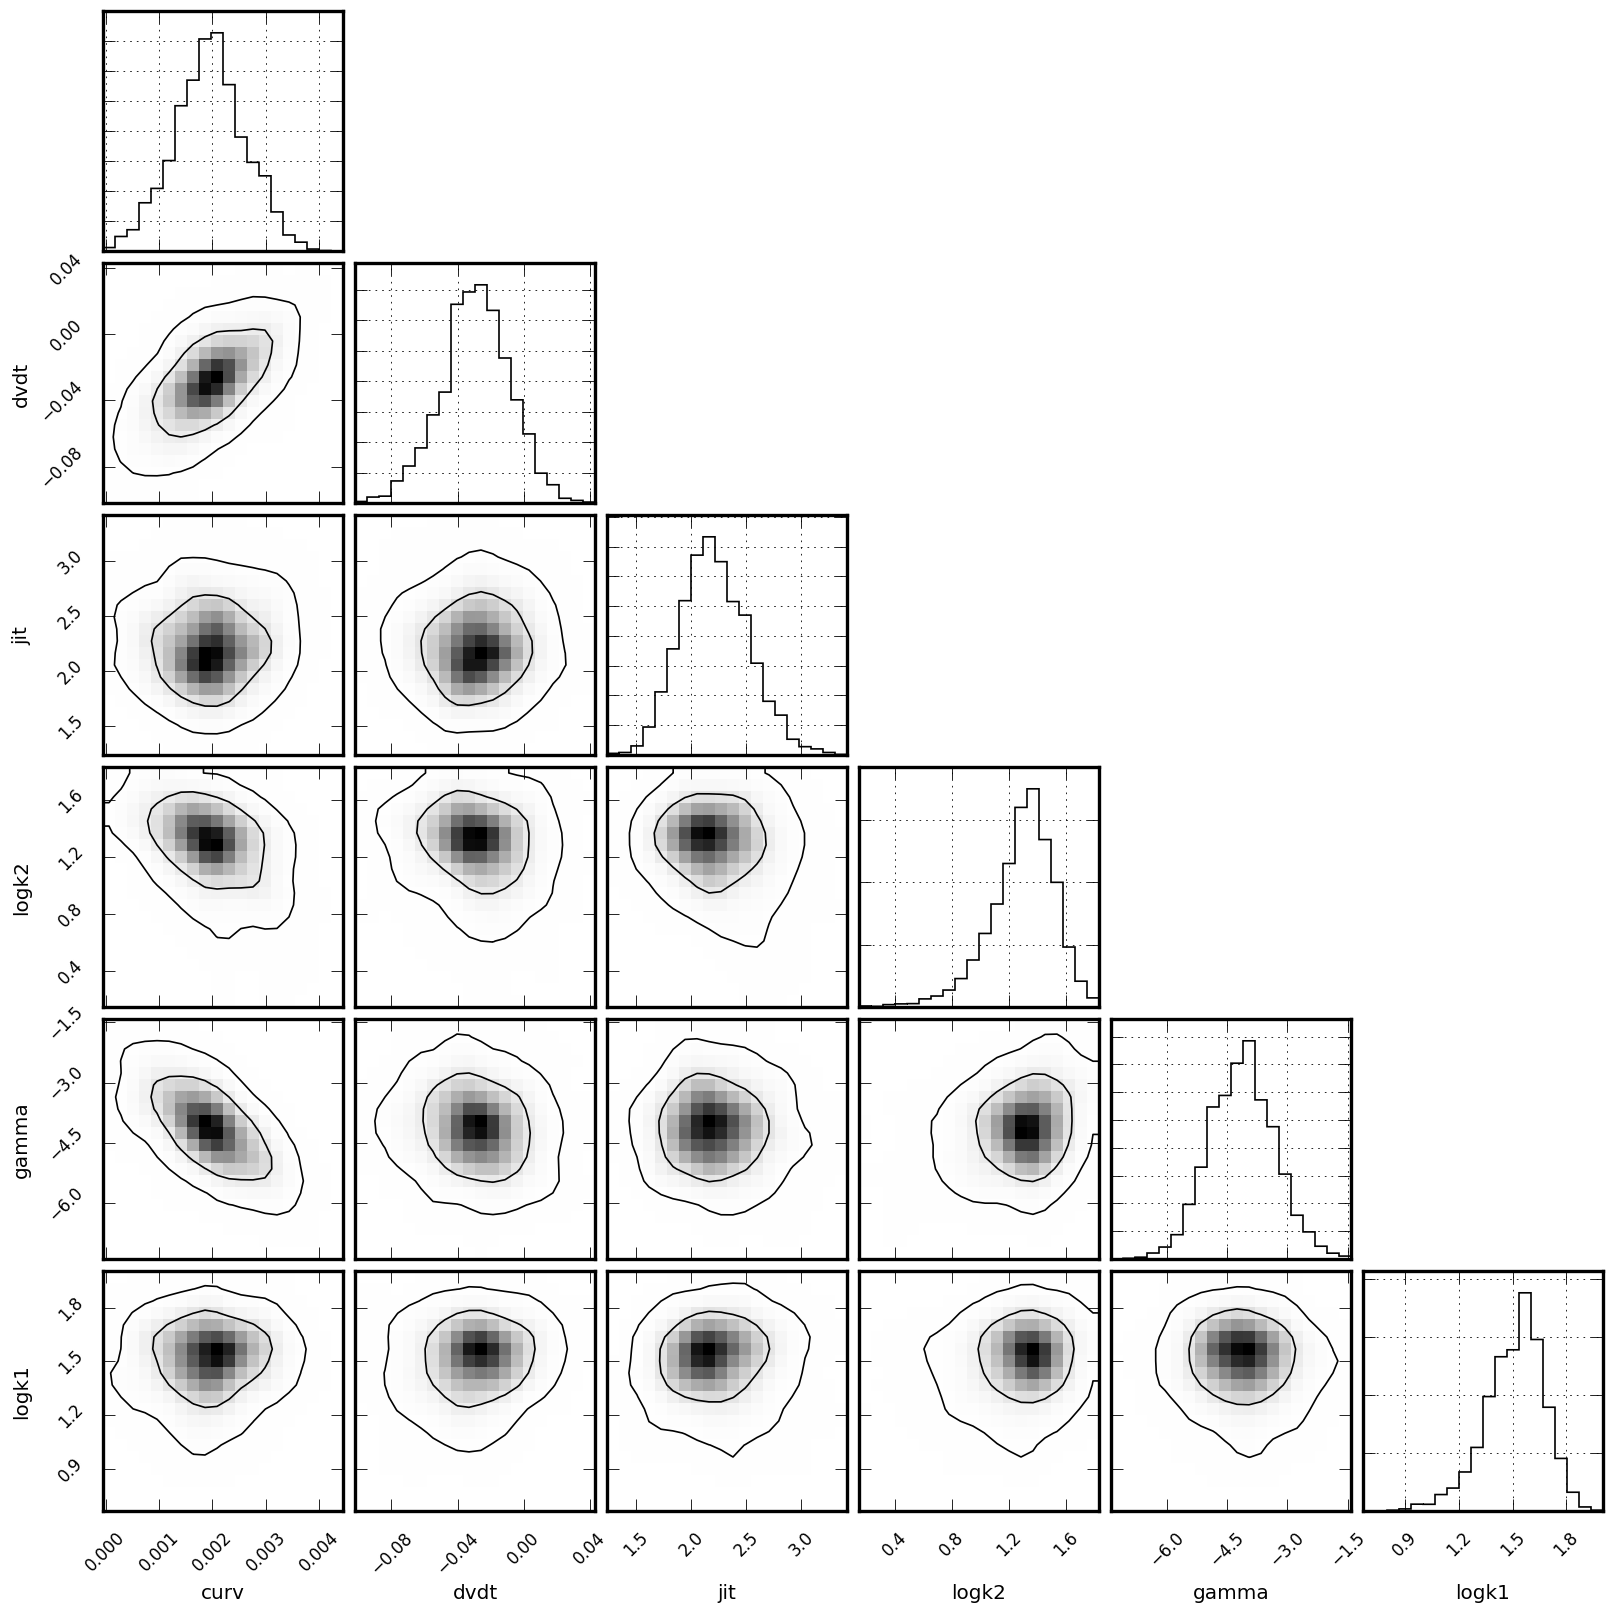

In [25]:
df = radvel.mcmc(post,threads=1,nwalkers=20,nrun=1000)
labels = [k for k in post.vary.keys() if post.vary[k]]
fig = corner.corner(
    df[labels],
    labels=labels,
    levels=[0.68,0.95],
    plot_datapoints=False,
    smooth=True,
    bins=20
    )

/net/calla.ifa.hawaii.edu/Volumes/indicium/u/bfulton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


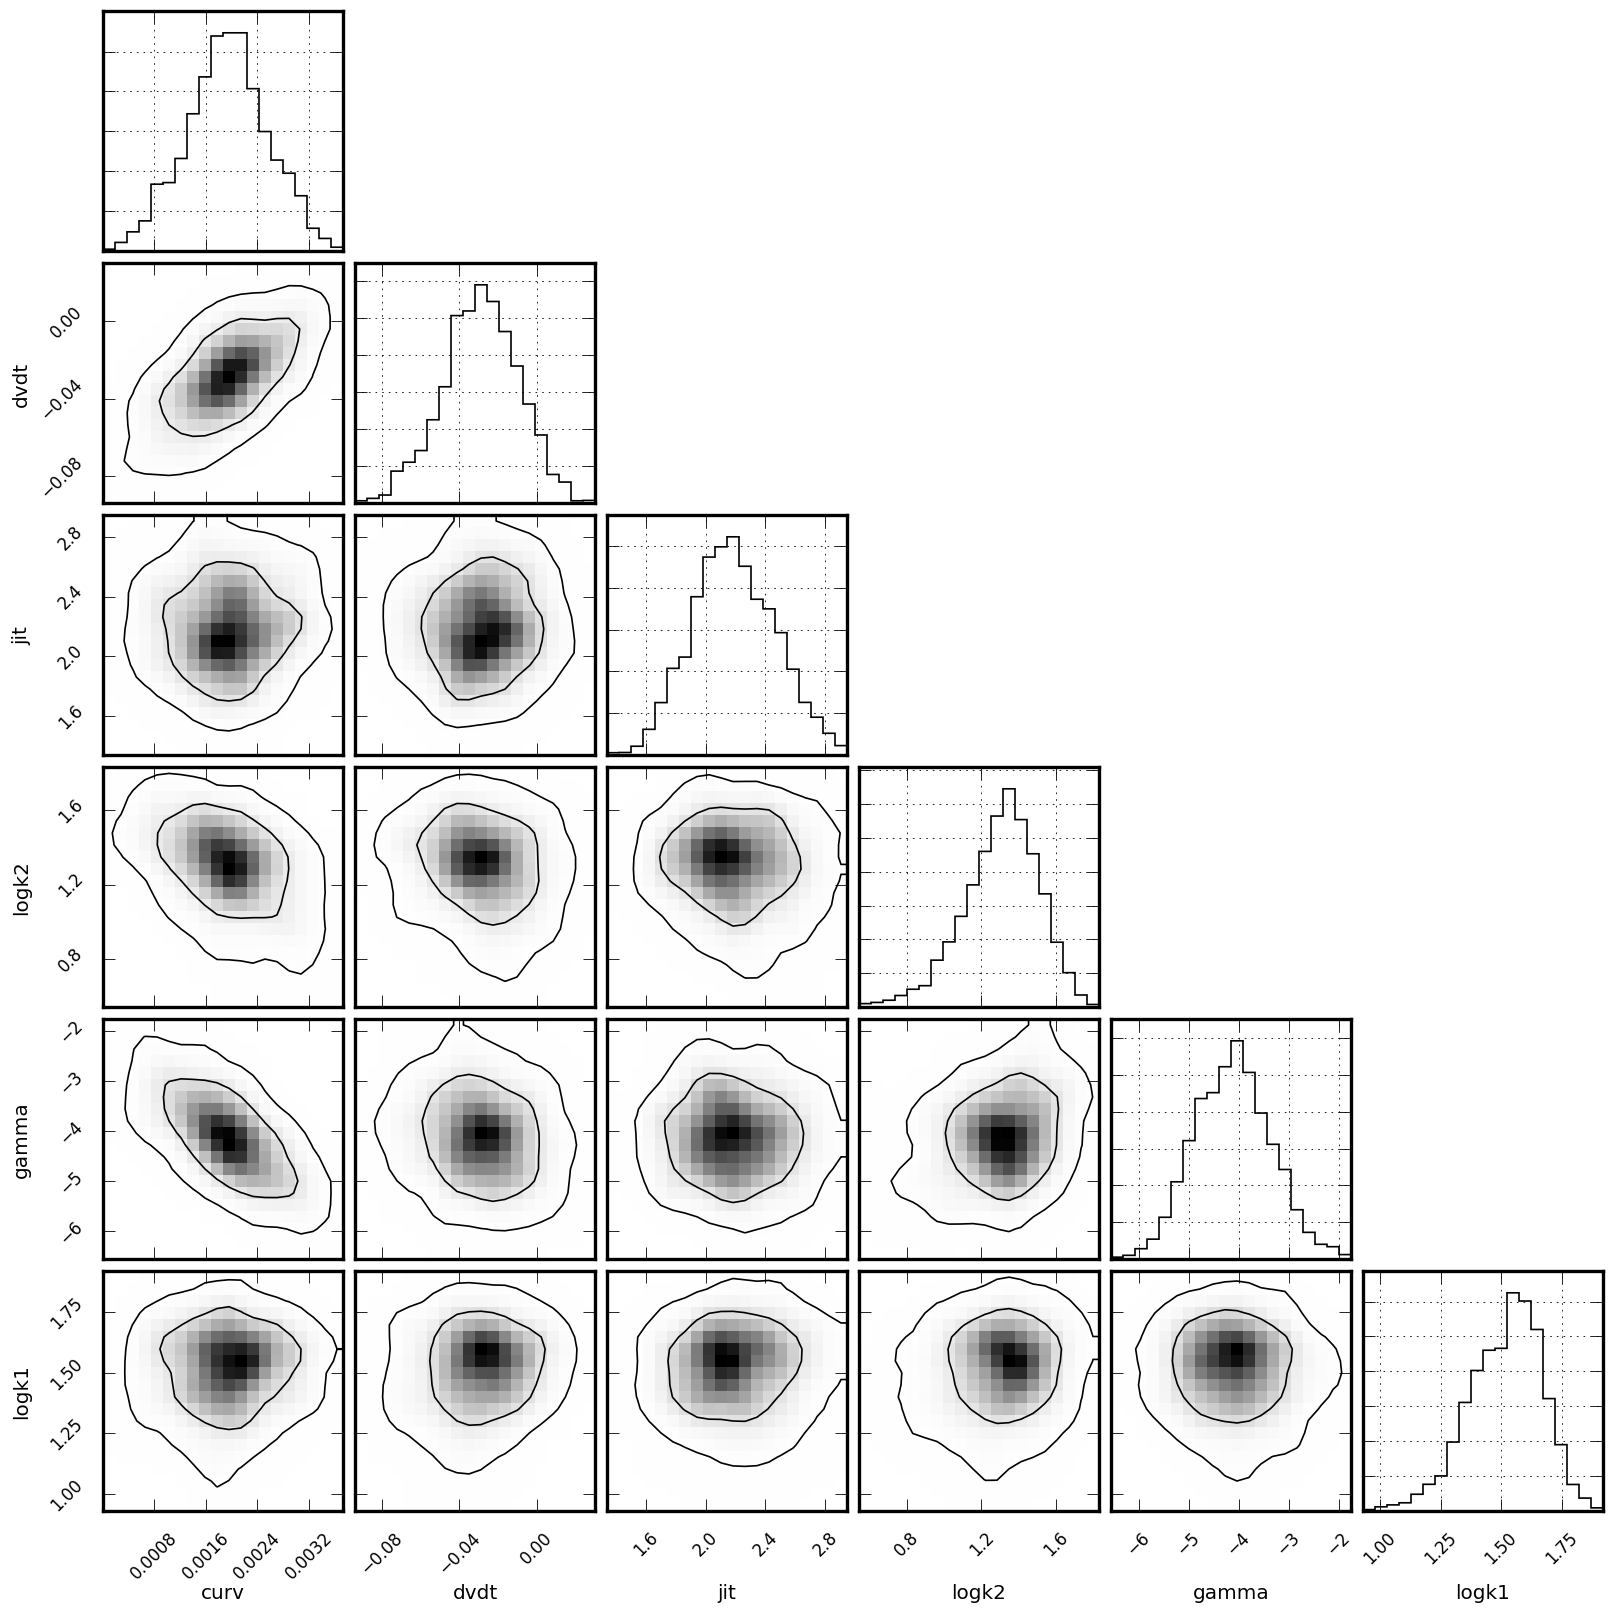

In [26]:
labels = [k for k in post.vary.keys() if post.vary[k]]
fig = corner.corner(
    df.sort('lnprobability').iloc[1000:][labels],
    labels=labels,
    levels=[0.68,0.95],
    plot_datapoints=False,
    smooth=True,
    bins=20
    )

Fit EPIC-2307 RV data
=========================
1. eccentric orbits
2. fixed period, time of transit

parameter                     value      vary
curv                           0.01       True
dvdt                          -0.02       True
gamma                           0.1       True
jit                        0.693147       True
logk1                           1.1       True
logk2                           1.1       True
per1                        20.8851      False
per2                        42.3638      False
secosw1                         0.1       True
secosw2                         0.1       True
sesinw1                         0.1       True
sesinw2                         0.1       True
tc1                          2072.8      False
tc2                         2082.62      False



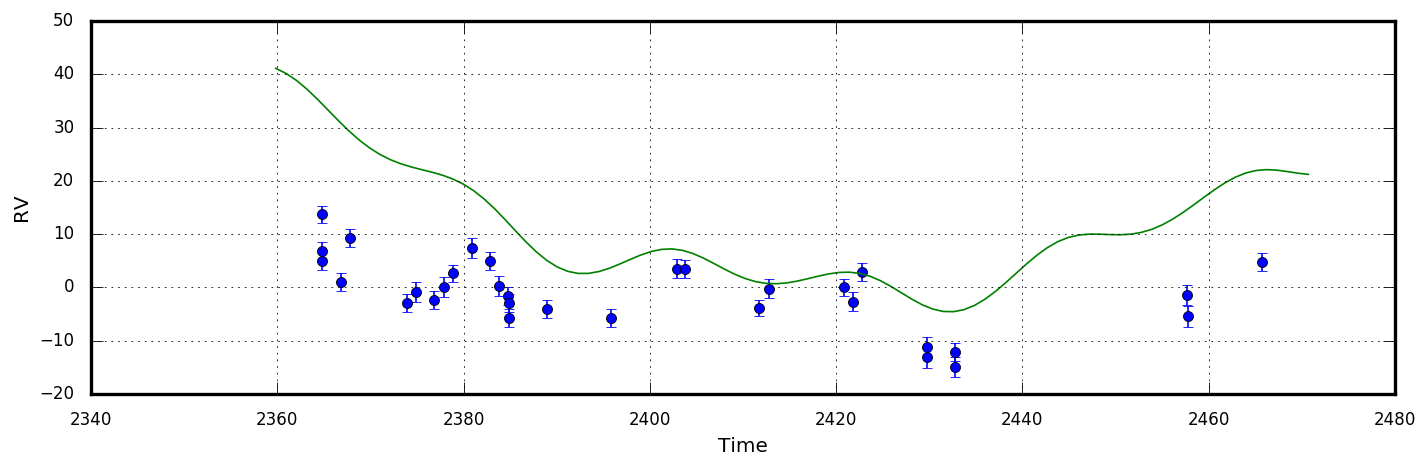

In [27]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, array(rv.t), array(rv.vel), array(rv.errvel))

# Eccentric orbits
like.params['gamma'] = 0.1
like.params['jit'] = np.log(2)

# Some syntactic sugar to update multiple fields at once
like.vary.update(per1=False,per2=False,tc1=False,tc2=False)
like.params.update(secosw1=0.1,sesinw1=0.1,secosw2=0.1,sesinw2=0.1)
plot_results(like) # plot best fit model
print like

parameter                     value      vary
curv                    -0.00052869       True
dvdt                     -0.0328122       True
gamma                    -0.0684173       True
jit                        0.893749       True
logk1                       1.65295       True
logk2                       1.75556       True
per1                        20.8851      False
per2                        42.3638      False
secosw1                    0.470784       True
secosw2                    0.027403       True
sesinw1                    0.062667       True
sesinw2                   0.0704479       True
tc1                          2072.8      False
tc2                         2082.62      False
Priors
------
Eccentricity constrained to be < 0.99
Gaussian prior on jit, mu=0.69314718056, sigma=0.1



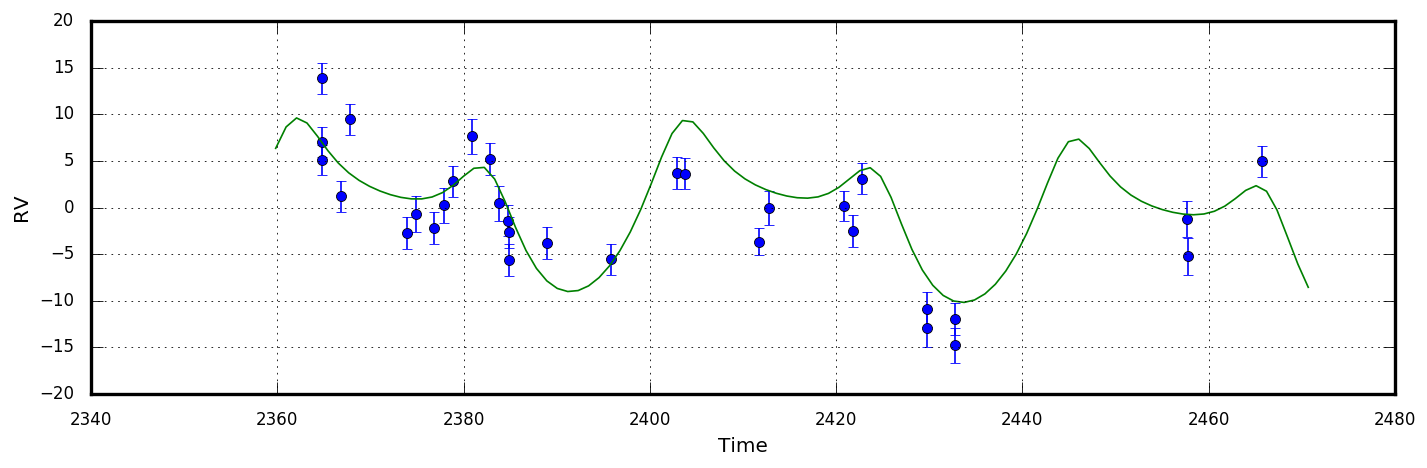

In [28]:
post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.EccentricityPrior( 2 )]
post.priors += [radvel.prior.Gaussian( 'jit', log(2),0.1)]

#plot_results(like) # Plot initial model
res  = optimize.minimize(
    post.neglogprob_array, 
    post.get_vary_params(), 
    method='Nelder-Mead',)

plot_results(like) # plot best fit model
print post



MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


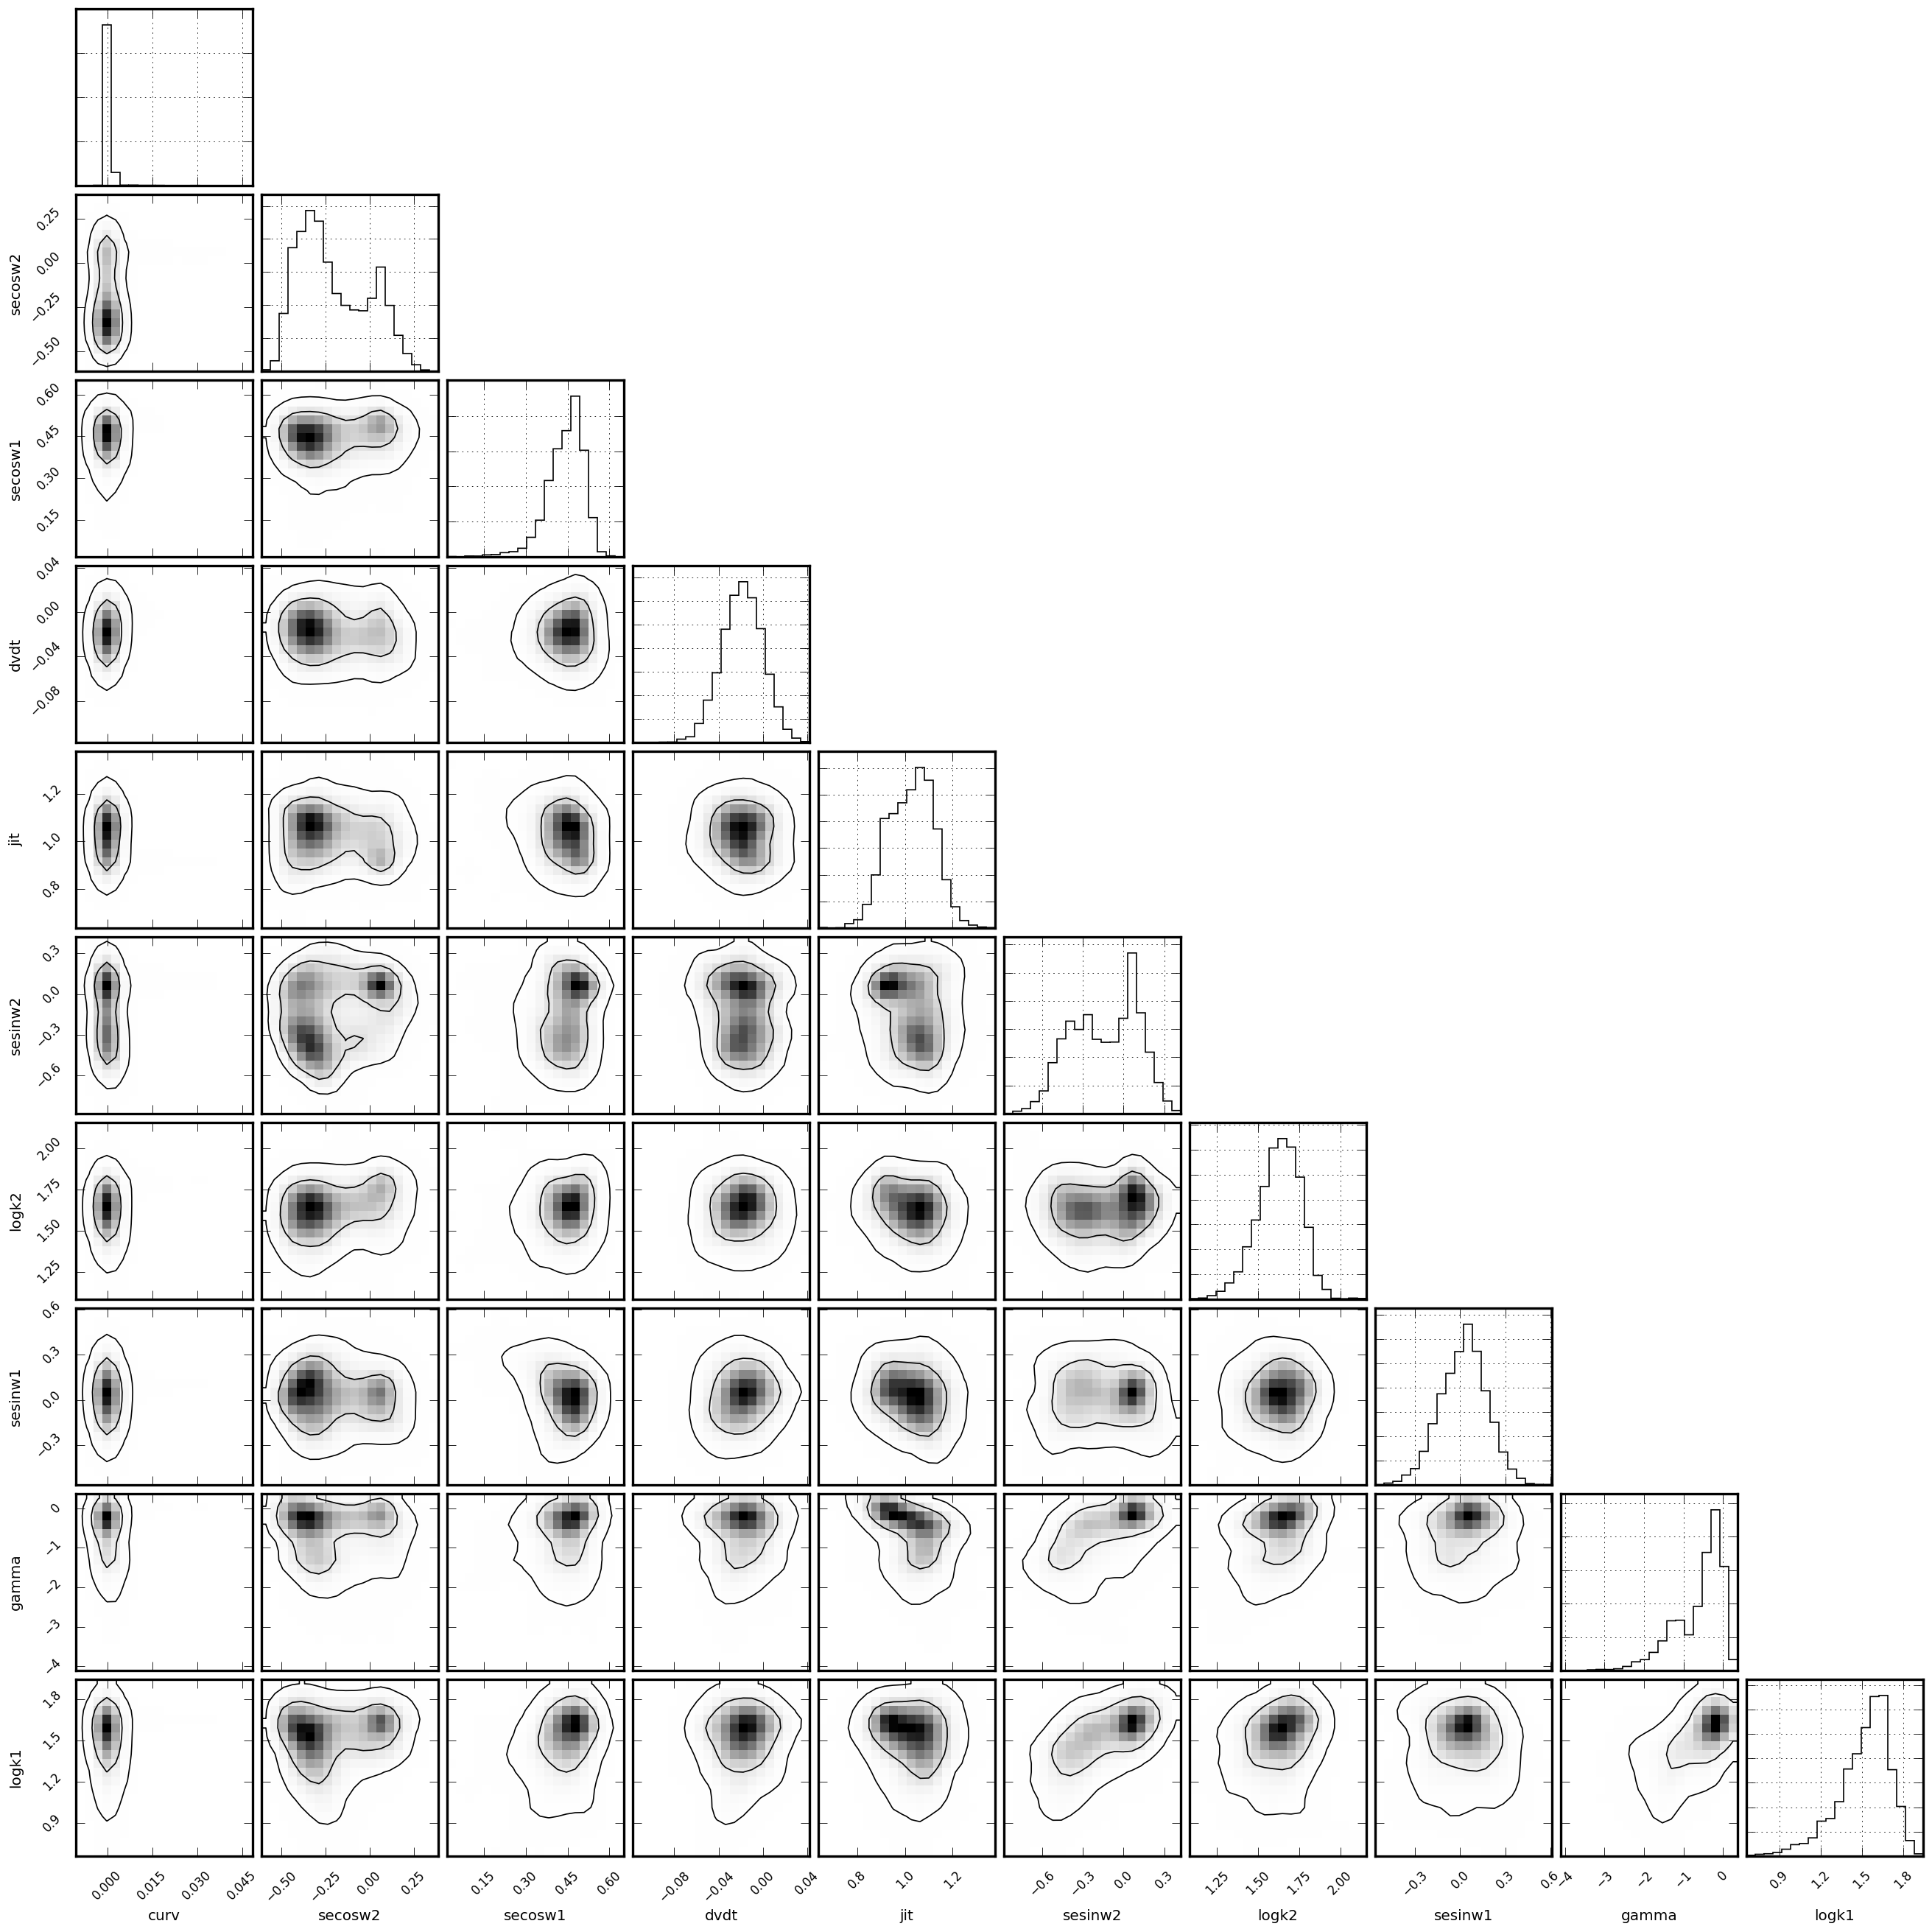

In [29]:
df = radvel.mcmc(post,threads=1,nwalkers=20,nrun=1000)
labels = [k for k in post.vary.keys() if post.vary[k]]
fig = corner.corner(
    df[labels],labels=labels,levels=[0.68,0.95],plot_datapoints=False,smooth=True,bins=20
    )

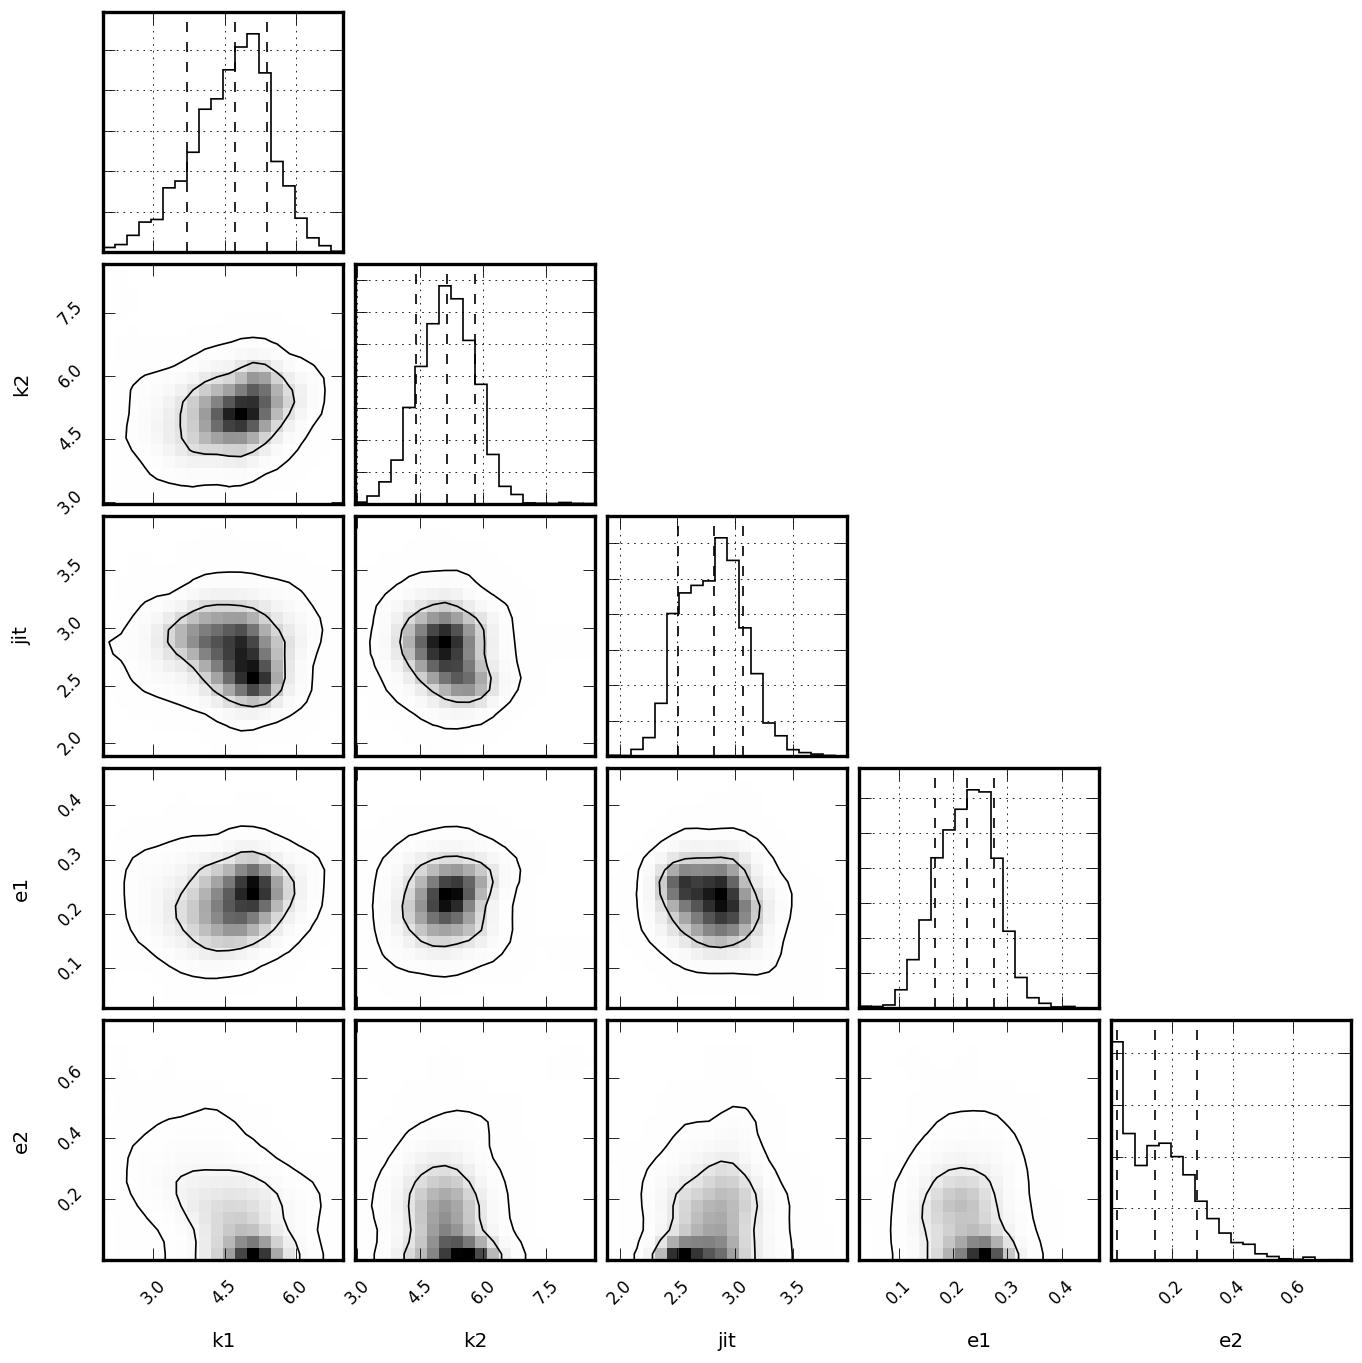

In [31]:
df['k1'] = exp(df['logk1'])
df['k2'] = exp(df['logk2'])
df['jit'] = exp(df['jit'])
df['e1'] = df['secosw1']**2 + df['sesinw1']**2
df['e2'] = df['secosw2']**2 + df['sesinw2']**2

df['ecosw1'] = df['secosw1']*np.sqrt(df['e1'])
df['esinw1'] = df['sesinw1']*np.sqrt(df['e1'])

df['ecosw2'] = df['secosw2']*np.sqrt(df['e2'])
df['esinw2'] = df['sesinw2']*np.sqrt(df['e2'])


labels = 'k1 k2 jit e1 e2'.split()
fig = corner.corner(
    df[labels],
    labels=labels,
    levels=[0.68,0.95],
    plot_datapoints=False,
    smooth=True,
    bins=20,
    quantiles=[.14,.5,.84]
    )

In [32]:
df[labels].describe()

,k1,k2,jit,e1,e2
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,4.630412,5.132501,2.804507,0.224088,0.159073
std,0.822311,0.671554,0.264274,0.052689,0.123412
min,1.934825,2.950905,1.892043,0.026691,0.000068
25%,4.111741,4.676457,2.601517,0.185503,0.052498
50%,4.725541,5.140397,2.814210,0.226436,0.144293
75%,5.211504,5.593012,2.989283,0.261594,0.237280
max,6.998874,8.655609,3.964304,0.468593,0.789379


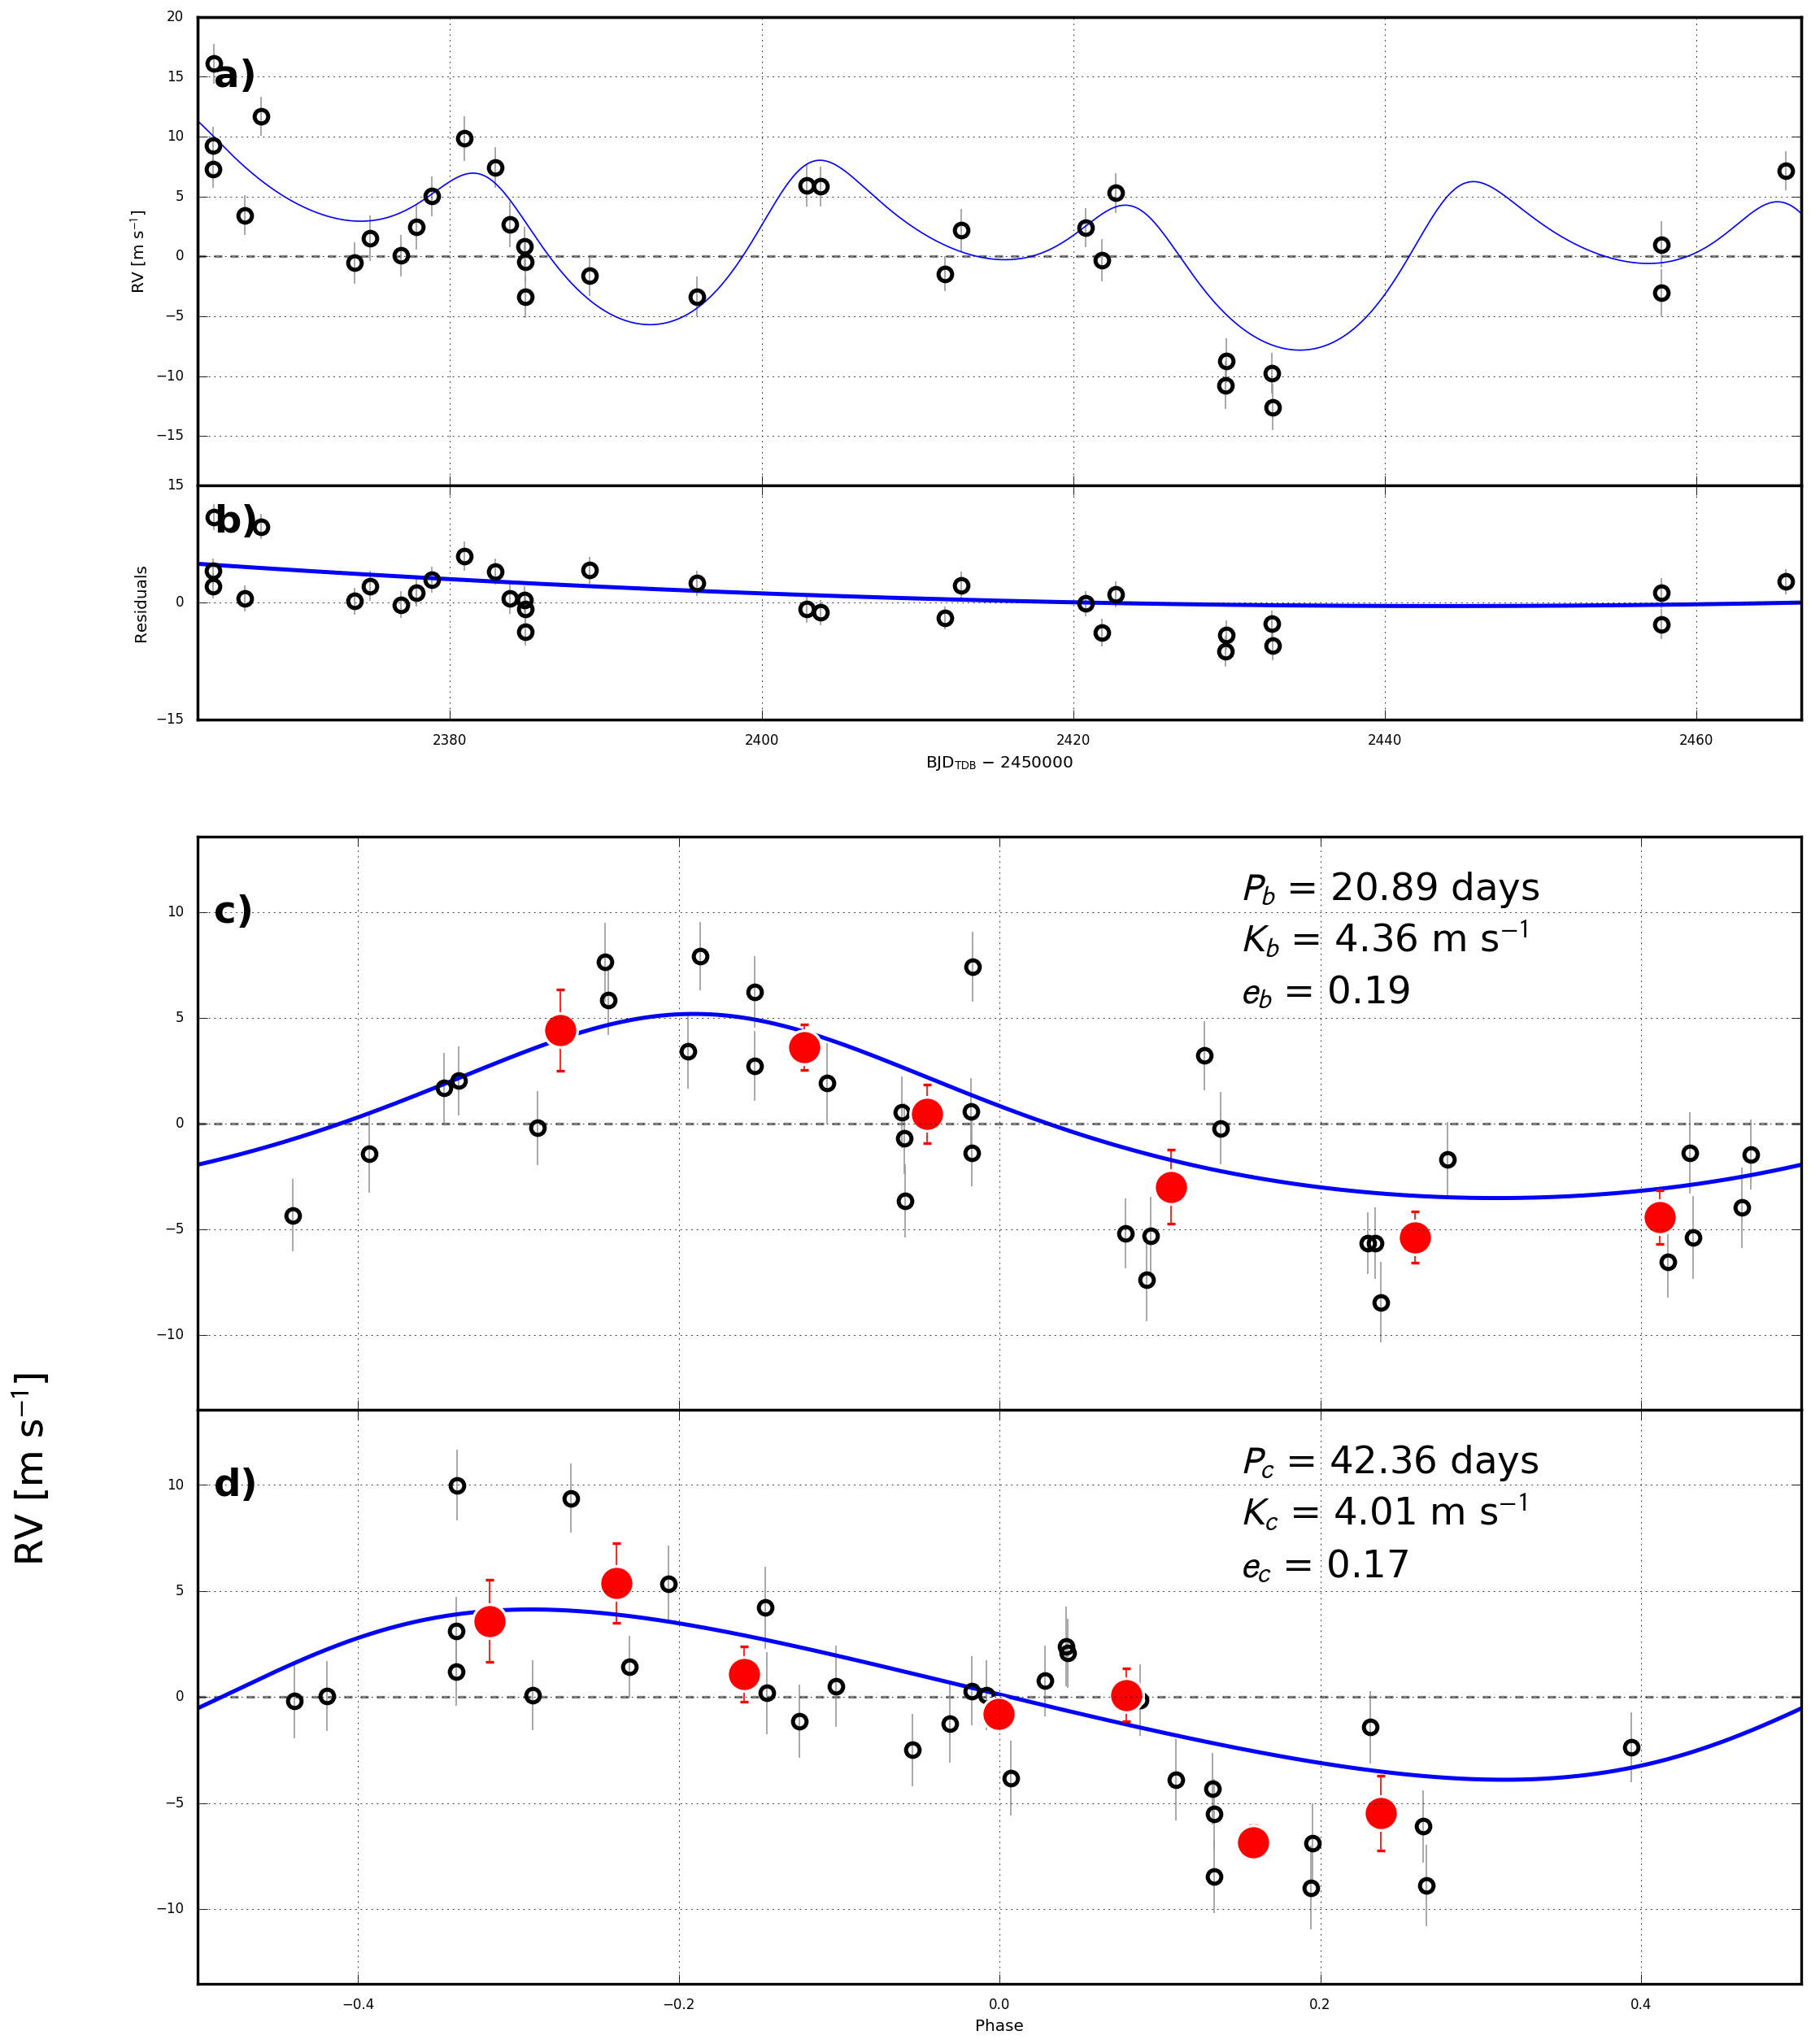

In [33]:
radvel.plotting.rv_multipanel_plot(post)